<a href="https://colab.research.google.com/github/AmelxJamal/STEM-Away-Internship/blob/master/Notebook_STEM_Away.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.9 MB/s 
     |████████████████████████████████| 4.7 MB 32.2 MB/s 
     |████████████████████████████████| 1.2 MB 47.6 MB/s 
     |████████████████████████████████| 101 kB 15.2 MB/s 
     |████████████████████████████████| 596 kB 58.2 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d625df96d5d46340d61cfd1809afc332eeaf4257db079a8f618f7cd1d0080e4e
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Kaggle Quora Dataset

In [3]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=531bab7930fb40b5e81e45703de56385c39cef8464f1b8c2dc3057013c1adcb7
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
!mkdir ~/.kaggle

In [5]:
!cp /content/kaggle.json /root/.kaggle

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
import os
os.environ["KAGGLE_CONFIG_"] =' /content/kaggle.json'

In [8]:
!kaggle competitions download -c quora-question-pairs

 98% 302M/309M [00:02<00:00, 204MB/s]
100% 309M/309M [00:02<00:00, 157MB/s]


In [9]:
!unzip /content/quora-question-pairs.zip

Archive:  /content/quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [10]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [11]:
train_df = pd.read_csv('/content/train.csv')
train_df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [12]:
test_df = pd.read_csv('/content/test.csv')
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Retrieval System

In [13]:
train_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [13]:
x = train_df[['id', 'qid1', 'qid2', 'question1', 'question2']]
y = train_df.is_duplicate
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.99, random_state = 0)

In [14]:
x_train.shape

(4042, 5)

In [15]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch
import pandas as pd

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")


#We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
bi_encoder.max_seq_length = 256     #Truncate long passages to 256 tokens
top_k = 32                          #Number of passages we want to retrieve with the bi-encoder

#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# df = pd.read_csv('Questions.csv') --> kaggle dataset
# passages = df.body[:9000].to_numpy()


qoura = x_train.question1.to_numpy()
passages = qoura
print("Passages:", len(passages))

# We encode all passages into our vector space. This takes about 5 minutes (depends on your GPU speed)
corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Passages: 4042


Batches:   0%|          | 0/127 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


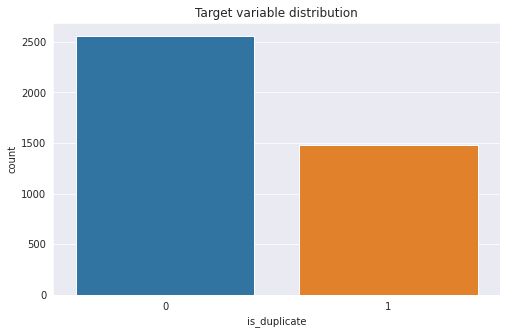

In [16]:
# Target variable distribution
train_sampled = x_train
train_sampled['is_duplicate'] = y_train
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train_sampled["is_duplicate"])
plt.title('Target variable distribution')
plt.show()

In [17]:
# This function will search all wikipedia articles for passages that
# answer the query
def search(query, top=3):
    # print("Input question:", query)

    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-5 hits from bi-encoder
    # print("\n-------------------------\n")
    # print("Top-3 Bi-Encoder Retrieval hits")
    bi_encoder_hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    # print(bi_encoder_hits[:2])
    bi_list, scores = [],[]
    for hit in bi_encoder_hits[0:top]:
        bi_list.append(passages[hit['corpus_id']])
        scores.append(hit['score'])

    # Output of top-5 hits from re-ranker
    # print("\n-------------------------\n")
    # print("Top-3 Cross-Encoder Re-ranker hits")
    cross_encoder_hits = sorted(bi_encoder_hits, key=lambda x: x['cross-score'], reverse=True)
    cross_list, scores_cross = [], []
    for hit in cross_encoder_hits[0:3]:
        cross_list.append((passages[hit['corpus_id']]))
        scores_cross.append(hit['cross-score'])
    return bi_list, cross_list, scores, scores_cross

In [18]:
from collections import defaultdict
def compute_hits(embeddings, questions_list, model = 'cross', top=3):
  hits_dict = defaultdict(lambda: 0.0)
  for idx, question in enumerate(questions_list):
    hits = []
    bi_hits, cross_hit, bi_scores, cross_scores = search(question, top=top)
    if model == 'bi':
      hits_dict[idx] = (bi_hits, bi_scores)
    else:
      hits_dict[idx] = (cross_hit, cross_scores)
  return hits_dict

In [25]:
def evaluate(list_hits, list_question2, labels):
  counts, length, TP, FP, TN, FN = 0,0,0,0,0,0
  TP_score, FP_score, TN_score, FN_score = [], [], [], []
  for idx, q in enumerate(list_question2):
      length +=1
      if labels[idx] == 1 and q in list_hits[idx][0]:
        counts+=1
        TP+=1
        # TP_score.append(list_hits[idx][1][])
      if labels[idx] == 0 and q not in list_hits[idx][0]:
        counts+=1
        TN+=1
      if labels[idx] == 1 and q not in list_hits[idx][0]:
        FN+=1
      if labels[idx] == 0 and q in list_hits[idx][0]:
        FP+=1

  accuracy = (counts/length)*100
  sensitivity = TP/(TP+FN)
  specificity = TN/(TN+FP)
  FPR = 1-specificity
  return accuracy, sensitivity, specificity, FPR, TP,TN,FP,FN

In [20]:
hits = compute_hits(corpus_embeddings, x_train.question2.to_numpy(),top=5)

In [26]:
accuracy, sensitivity, specificity, FPR , TP, TN, FP, FN= evaluate(hits, x_train.question1.to_numpy(),x_train.is_duplicate.to_numpy())

In [28]:
accuracy, sensitivity, specificity, FPR, TP,TN,FP,FN

(49.77733795150915,
 0.9111111111111111,
 0.2577238951896754,
 0.7422761048103246,
 1353,
 659,
 1898,
 132)

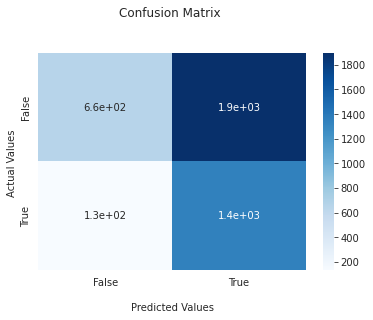

In [29]:
import seaborn as sns

cf = np.array([
    [TN, FP],
    [FN, TP]
])
ax = sns.heatmap(cf, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [24]:
for query in train_df.question2[:2].to_numpy():
  search(query)

# Pinecone

In [30]:
!pip install -qU pip pinecone-client

     |████████████████████████████████| 2.0 MB 5.3 MB/s 
     |████████████████████████████████| 160 kB 64.9 MB/s 
     |████████████████████████████████| 58 kB 7.9 MB/s 
     |████████████████████████████████| 269 kB 63.2 MB/s 


In [33]:
import pinecone
import os

api_key = '5b342d52-d0a7-4805-9145-3ff69c9853d6'
pinecone.init(api_key=api_key, environment='default')

In [ ]:
import pinecone.info

version_info = pinecone.info.version()
server_version = ".".join(version_info.server.split(".")[:2])
client_version = ".".join(version_info.client.split(".")[:2])

assert client_version == server_version, "Please upgrade pinecone-client."

In [ ]:
# Giving our index a name
index_name = "STEM Away"
# Delete the index, if an index of the same name already exists
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

In [ ]:
dimensions = 3
pinecone.create_index(name=index_name, dimension=dimensions, metric="cosine")

In [ ]:
index = pinecone.Index(index_name=index_name)

In [ ]:
index.upsert(vectors=zip(df.id, df.vector))  # insert vectors

In [ ]:
index.describe_index_stats()

In [ ]:
index.query(
    vector=[2., 2., 2.], 
    top_k=5, 
    include_values=True) # returns top_k matches

In [ ]:
pinecone.delete_index(index_name)